In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras import models, Model
import qkeras
from qkeras import *

# add noise (can downgrade full cnn but sparse cnn can ignore with thresholding)
# further sparsify (inflat the digits without changing the no. of active cells)

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

n_val = 10000
X_val = X_train[:n_val]
y_val = y_train[:n_val]
X_train = X_train[n_val:]
y_train = y_train[n_val:]

X_train = np.reshape(X_train, (-1,28,28,1)) / 255.
X_val = np.reshape(X_val, (-1,28,28,1)) / 255.
X_test = np.reshape(X_test, (-1,28,28,1)) / 255.

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

print("X_train.shape: " + str(X_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("y_val.shape: " + str(y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_test.shape: " + str(y_test.shape))

X_train.shape: (50000, 28, 28, 1)
y_train.shape: (50000, 10)
X_val.shape: (10000, 28, 28, 1)
y_val.shape: (10000, 10)
X_test.shape: (10000, 28, 28, 1)
y_test.shape: (10000, 10)


In [ ]:
def pool_pad_noise_inflate(img, pool_size, pool_type, target_size=None, noise_type=None, noise_level=0, inflate_factor=1):
    x = tf.convert_to_tensor(img, dtype=tf.float32)
    #x = tf.where(x<threshold, tf.zeros_like(x), x)

    k_h = k_w = pool_size

    if pool_type == 'max':
        pooled = tf.nn.max_pool2d(x, ksize=[1, k_h, k_w, 1], strides=[1, k_h, k_w, 1], padding='VALID')
    elif pool_type in ('avg'):
        pooled = tf.nn.avg_pool2d(x, ksize=[1, k_h, k_w, 1], strides=[1, k_h, k_w, 1], padding='VALID')

    old_h = tf.shape(x)[1]
    old_w = tf.shape(x)[2]
    new_h  = tf.shape(pooled)[1]
    new_w  = tf.shape(pooled)[2]

    if target_size is None:
        target_h, target_w = old_h, old_w
    else:
        target_h, target_w = target_size

    pad_y = target_h - new_h
    pad_x = target_w - new_w
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left

    padded = tf.pad(
        pooled,
        [[0, 0], # batch
         [pad_top, pad_bottom], # h
         [pad_left, pad_right], # w
         [0, 0]], # c
        mode='CONSTANT',
        constant_values=0
    )

    max_per_img = tf.reduce_max(padded, axis=[1,2,3], keepdims=True)
    padded = tf.math.divide_no_nan(padded, max_per_img)

    if inflate_factor != 1.0:
        h, w = tf.shape(padded)[1], tf.shape(padded)[2]
        
        center_h = tf.cast(h-1, tf.float32) / 2
        center_w = tf.cast(w-1, tf.float32) / 2
        
        coords = tf.where(padded>0)
        vals = tf.gather_nd(padded, coords)
        b_idx = coords[:,0]
        y0 = tf.cast(coords[:,1], tf.float32)
        x0 = tf.cast(coords[:,2], tf.float32)
        c_idx = coords[:,3]
        
        y_new = tf.round((y0 - center_h) * inflate_factor + center_h)
        x_new = tf.round((x0 - center_w) * inflate_factor + center_w)
        
        y_new = tf.clip_by_value(y_new, 0, tf.cast(h-1, tf.float32))
        x_new = tf.clip_by_value(x_new, 0, tf.cast(w-1, tf.float32))
        
        new_idx = tf.stack([tf.cast(b_idx, tf.int32),
                            tf.cast(y_new, tf.int32),
                            tf.cast(x_new, tf.int32),
                            tf.cast(c_idx, tf.int32)], axis=1)
        
        inflated = tf.zeros_like(padded)
        padded = tf.tensor_scatter_nd_update(inflated, new_idx, vals)
        
    if noise_level > 0:
        noise_mask = tf.cast(tf.equal(padded, 0), tf.float32)
        if noise_type=='uniform':
            noise = tf.random.uniform(tf.shape(padded), minval=0, maxval=noise_level, dtype=tf.float32)
        elif noise_type=='poisson':
            noise = tf.random.poisson(shape=tf.shape(padded), lam=noise_level, dtype=tf.float32)
            noise = tf.clip_by_value(noise, 0, noise_level * 3)
        padded = padded + noise * noise_mask

        #max_per_img = tf.reduce_max(padded, axis=[1,2,3], keepdims=True)
        #padded = tf.math.divide_no_nan(padded, max_per_img)

    return padded.numpy()

def plot_sparse(x_original, x_modified, n_example, threshold):
    img1 = x_original[n_example+1011]
    img2 = x_modified[n_example+1011]
    img3 = np.where(img2 > threshold, img2, 0)

    print('no. of active pixels (original): ' + str(np.count_nonzero(img1)) + ' / ' + str(img1.size) + ' = ' + str(np.count_nonzero(img1)/img1.size))
    print('no. of active pixels (modified): ' + str(np.count_nonzero(img2)) + ' / ' + str(img2.size) + ' = ' + str(np.count_nonzero(img2)/img2.size))
    print(f'no. of active pixels (modified, threshold > {threshold}): ' + str(np.count_nonzero(img3)) + ' / ' + str(img3.size) + ' = ' + str(np.count_nonzero(img3)/img3.size))

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[2].imshow(img3)
    plt.tight_layout()
    plt.show()

no. of active pixels (original): 151 / 784 = 0.19260204081632654
no. of active pixels (modified): 1600 / 1600 = 1.0
no. of active pixels (modified, threshold > 0.2997): 17 / 1600 = 0.010625


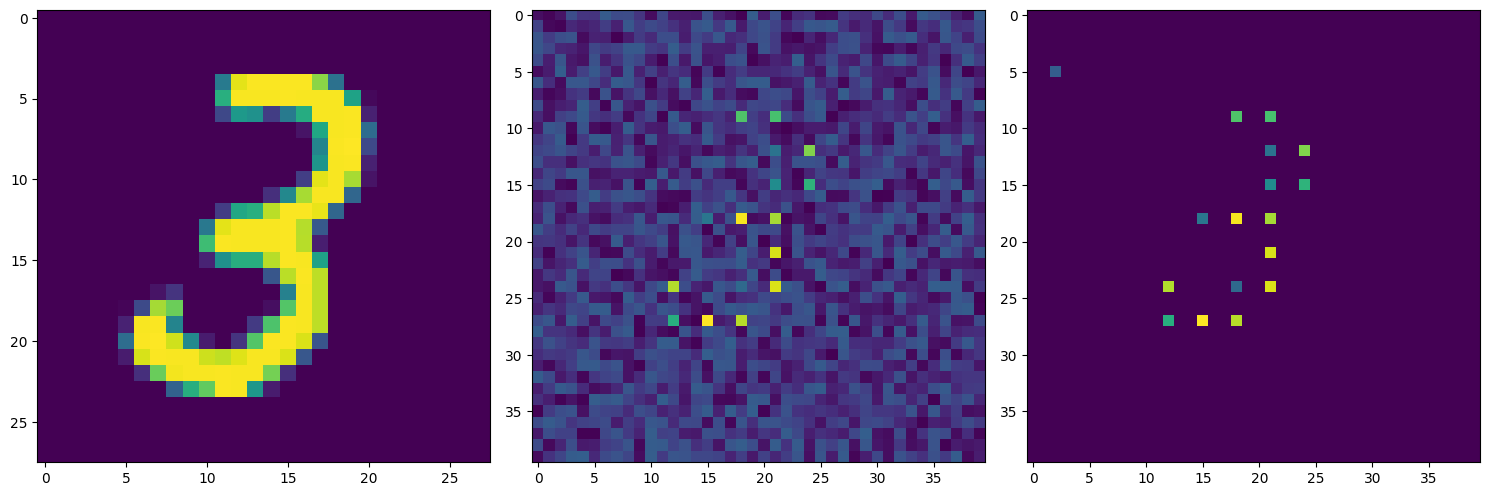

no. of active pixels (original): 129 / 784 = 0.16454081632653061
no. of active pixels (modified): 1600 / 1600 = 1.0
no. of active pixels (modified, threshold > 0.2997): 14 / 1600 = 0.00875


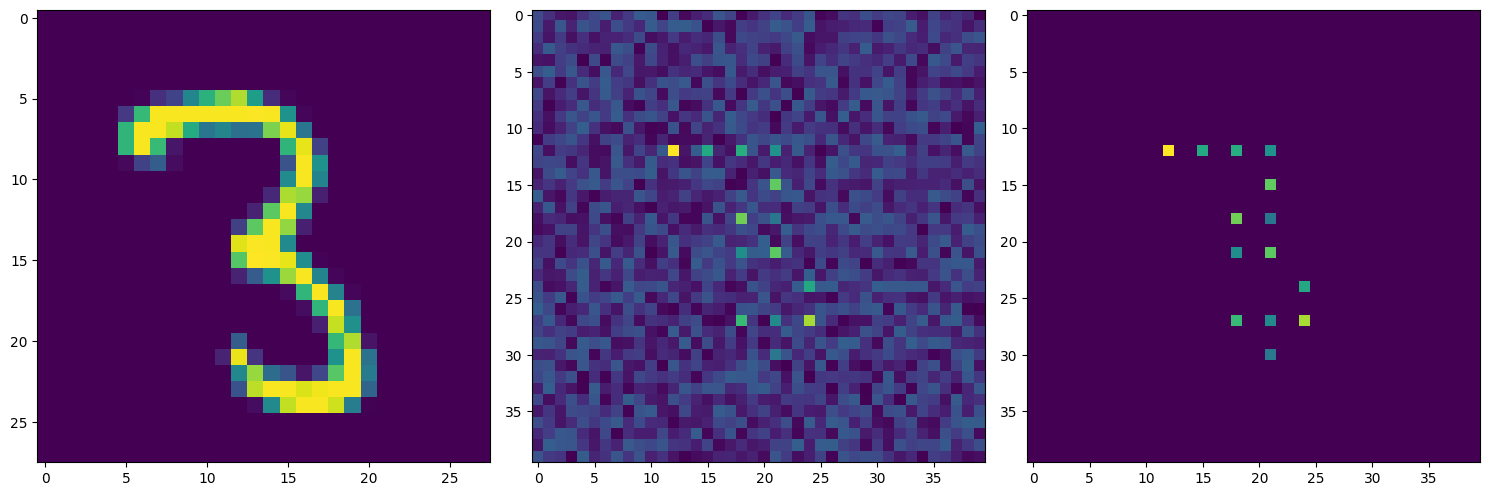

no. of active pixels (original): 197 / 784 = 0.2512755102040816
no. of active pixels (modified): 1600 / 1600 = 1.0
no. of active pixels (modified, threshold > 0.2997): 21 / 1600 = 0.013125


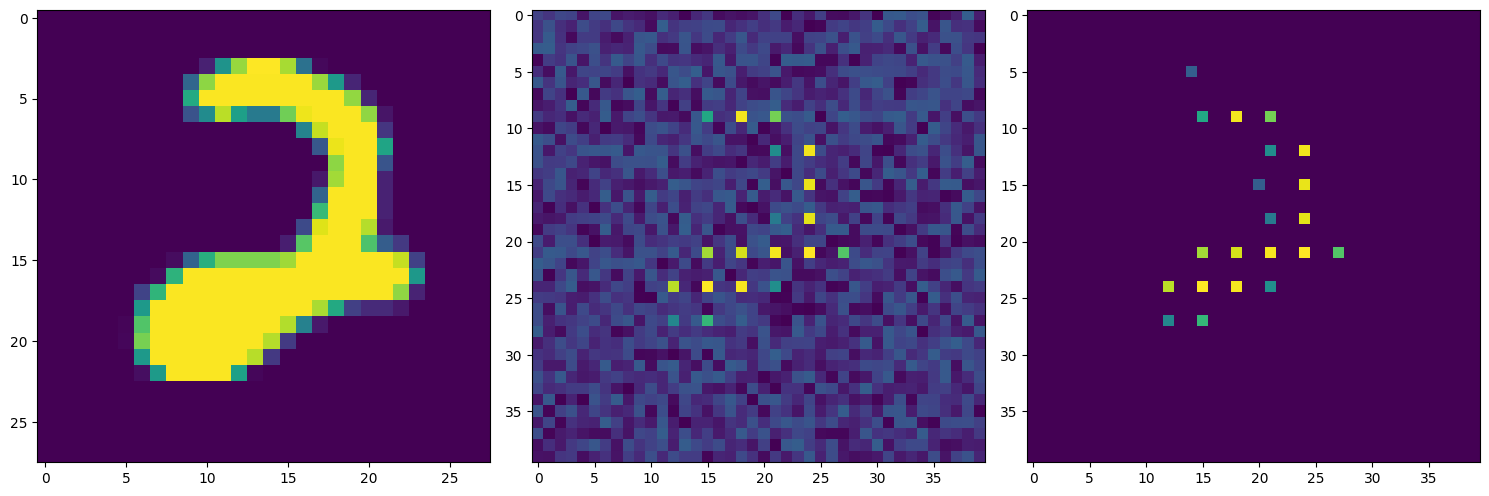

no. of active pixels (original): 177 / 784 = 0.22576530612244897
no. of active pixels (modified): 1600 / 1600 = 1.0
no. of active pixels (modified, threshold > 0.2997): 22 / 1600 = 0.01375


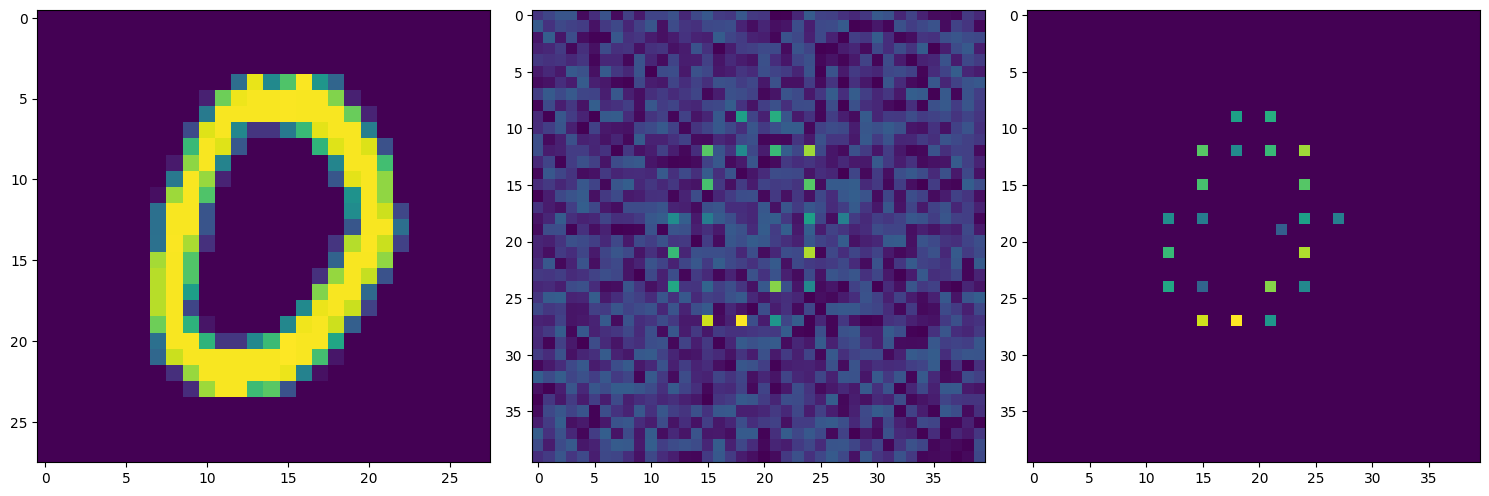

no. of active pixels (original): 162 / 784 = 0.2066326530612245
no. of active pixels (modified): 1600 / 1600 = 1.0
no. of active pixels (modified, threshold > 0.2997): 19 / 1600 = 0.011875


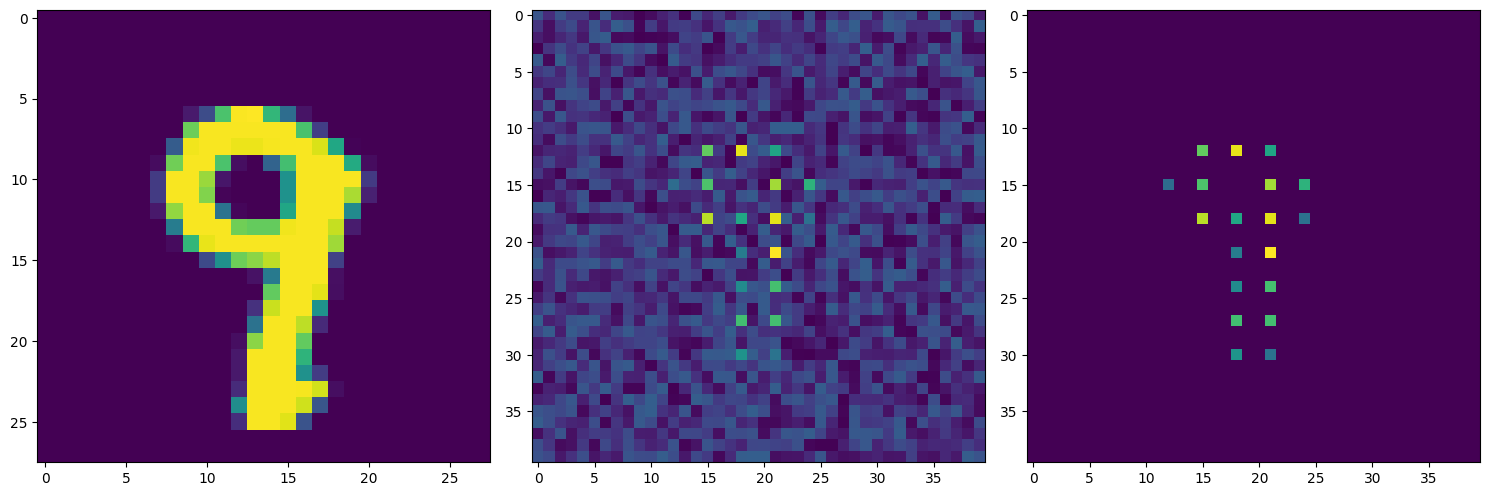

In [4]:
noise_type='uniform'
#noise_type='poisson'
noise_level=0.3
inflate_factor=3
threshold=0.2997

x_train = pool_pad_noise_inflate(X_train, pool_size=3, pool_type='avg', target_size=(40,40), noise_type=noise_type, noise_level=noise_level, inflate_factor=inflate_factor)
x_val = pool_pad_noise_inflate(X_val, pool_size=3, pool_type='avg', target_size=(40,40), noise_type=noise_type, noise_level=noise_level, inflate_factor=inflate_factor)
x_test = pool_pad_noise_inflate(X_test, pool_size=3, pool_type='avg', target_size=(40,40), noise_type=noise_type, noise_level=noise_level, inflate_factor=inflate_factor)

for i in range(5):
    plot_sparse(X_train, x_train, i, threshold=threshold)

In [5]:
class InputReduce(tf.keras.layers.Layer):
    def __init__(self, n_max_pixels, threshold, **kwargs):
        super(InputReduce, self).__init__(**kwargs)
        self.n_max_pixels = n_max_pixels
        self.threshold = threshold

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]

        '''
        if self.threshold is not None:
            cond = inputs > self.threshold
        else:
            cond = inputs != 0
        active_flag = tf.cast(tf.reduce_any(cond, axis=-1), tf.int32)
        '''

        # to be consistent with hls, check only the first input channel
        if self.threshold is not None:
            active_flag = tf.cast(inputs[..., 0] > self.threshold, tf.int32)
        else:
            active_flag = tf.cast(inputs[..., 0] != 0, tf.int32)

        active_flag_flat = tf.reshape(active_flag, [batch_size, h * w])
        active_count = tf.cumsum(active_flag_flat, axis=1)

        keep_mask_flat = tf.cast(tf.logical_and(active_flag_flat == 1, active_count <= self.n_max_pixels), inputs.dtype)
        keep_mask = tf.reshape(keep_mask_flat, [batch_size, h, w, 1])

        inputs_reduced = inputs * keep_mask
        return inputs_reduced, keep_mask

    def get_config(self):
        config = super(InputReduce, self).get_config()
        config.update({
            "n_max_pixels": self.n_max_pixels,
            "threshold": self.threshold
        })
        return config
    

class RemoveDilatedPixels(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RemoveDilatedPixels, self).__init__(**kwargs)

    def call(self, inputs):
        x, mask = inputs
        mask = tf.cast(mask, x.dtype)
        removed = x * mask
        return removed

    def get_config(self):
        config = super(RemoveDilatedPixels, self).get_config()
        return config


In [6]:
for i, img in enumerate(x_train[:2]):
    print(f"Example {i}:")
    img2d = img[..., 0]
    for row in img2d:
        row_str = " ".join(
            "_____" if val == 0 
            else f"{val:.3f}"
            for val in row
        )
        print(row_str)
    print()

Example 0:
0.268 0.287 0.010 0.079 0.140 0.103 0.125 0.275 0.170 0.272 0.033 0.177 0.287 0.014 0.104 0.071 0.277 0.222 0.105 0.158 0.235 0.034 0.020 0.163 0.068 0.108 0.215 0.050 0.002 0.095 0.109 0.287 0.026 0.040 0.005 0.244 0.246 0.201 0.056 0.156
0.270 0.009 0.150 0.141 0.288 0.220 0.277 0.263 0.193 0.093 0.143 0.242 0.218 0.147 0.177 0.216 0.085 0.159 0.178 0.277 0.139 0.096 0.065 0.291 0.063 0.260 0.114 0.130 0.197 0.216 0.105 0.140 0.138 0.057 0.066 0.049 0.097 0.254 0.197 0.043
0.242 0.096 0.069 0.127 0.281 0.037 0.198 0.061 0.217 0.293 0.160 0.260 0.038 0.185 0.001 0.067 0.193 0.066 0.114 0.224 0.158 0.144 0.144 0.251 0.016 0.294 0.047 0.163 0.041 0.265 0.143 0.029 0.225 0.180 0.161 0.160 0.156 0.034 0.043 0.133
0.106 0.122 0.286 0.165 0.021 0.007 0.083 0.162 0.264 0.258 0.140 0.288 0.095 0.277 0.018 0.077 0.281 0.264 0.001 0.085 0.049 0.272 0.083 0.084 0.229 0.111 0.004 0.238 0.040 0.015 0.240 0.051 0.213 0.148 0.283 0.020 0.063 0.206 0.066 0.219
0.288 0.166 0.075 0.089 0.056

In [7]:
xx, mask = InputReduce(n_max_pixels=10, threshold=0.3)(x_train[:2])
xxx = RemoveDilatedPixels()((xx, mask))
print(xx.shape, xxx.shape)

(2, 40, 40, 1) (2, 40, 40, 1)


In [8]:
for i, img in enumerate(xxx[:2]):
    print(f"Example {i}:")
    img2d = img[..., 0]
    for row in img2d:
        row_str = " ".join(
            "_____" if val == 0
            else f"{val:.3f}"
            for val in row
        )
        print(row_str)
    print()

Example 0:
_____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____
_____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____
_____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____
_____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____
_____ _____ _____ _____ _____

In [9]:
quantizer = quantized_bits(6, 0, alpha=1)
quantized_relu = 'quantized_relu(6, 0)'

x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')
x, keep_mask = InputReduce(n_max_pixels=20, threshold=threshold, name='input_reduce')(x_in)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv1',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = RemoveDilatedPixels(name='remove1')((x, keep_mask))
x = QActivation(quantized_relu, name='relu1')(x)

x = AveragePooling2D(2, name='pool1')(x)
keep_mask = MaxPooling2D(2, name='mask_pool1')(keep_mask)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv2',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = RemoveDilatedPixels(name='remove2')((x, keep_mask))
x = QActivation(quantized_relu, name='relu2')(x)

x = AveragePooling2D(2, name='pool2')(x)
keep_mask = MaxPooling2D(2, name='mask_pool2')(keep_mask)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv3',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = RemoveDilatedPixels(name='remove3')((x, keep_mask))
x = QActivation(quantized_relu, name='relu3')(x)

x = Flatten(name='flatten')(x)

x = QDense(32, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
x = QActivation(quantized_relu, name='relu4')(x)

x = QDense(10, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
x = Activation('softmax', name='softmax')(x)

cnn_sparse = keras.Model(x_in, x, name='cnn_sparse')

cnn_sparse.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_sparse.summary()

Model: "cnn_sparse"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_in (InputLayer)           [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_reduce (InputReduce)  ((None, 40, 40, 1),          0         ['x_in[0][0]']                
                              (None, 40, 40, 1))                                                  
                                                                                                  
 conv1 (QConv2D)             (None, 40, 40, 3)            30        ['input_reduce[0][0]']        
                                                                                                  
 remove1 (RemoveDilatedPixe  (None, 40, 40, 3)            0         ['conv1[0][0]',      

In [10]:
quantizer = quantized_bits(6, 0, alpha=1)
quantized_relu = 'quantized_relu(6, 0)'

x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv1',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x_in)
x = QActivation(quantized_relu, name='relu1')(x)

x = AveragePooling2D(2, name='pool1')(x)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv2',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu2')(x)

x = AveragePooling2D(2, name='pool2')(x)

x = QConv2D(filters=3, kernel_size=(3, 3), use_bias=True, name='conv3',
            padding='same', strides=1,
            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = QActivation(quantized_relu, name='relu3')(x)

x = Flatten(name='flatten')(x)

x = QDense(32, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
x = QActivation(quantized_relu, name='relu4')(x)

x = QDense(10, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
x = Activation('softmax', name='softmax')(x)

cnn_full = keras.Model(x_in, x, name='cnn_full')

cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_full.summary()

Model: "cnn_full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 40, 40, 1)]       0         
                                                                 
 conv1 (QConv2D)             (None, 40, 40, 3)         30        
                                                                 
 relu1 (QActivation)         (None, 40, 40, 3)         0         
                                                                 
 pool1 (AveragePooling2D)    (None, 20, 20, 3)         0         
                                                                 
 conv2 (QConv2D)             (None, 20, 20, 3)         84        
                                                                 
 relu2 (QActivation)         (None, 20, 20, 3)         0         
                                                                 
 pool2 (AveragePooling2D)    (None, 10, 10, 3)         0  

Epoch 1/100
391/391 [==============================] - 5s 11ms/step - loss: 1.2409 - accuracy: 0.6462 - val_loss: 0.7402 - val_accuracy: 0.7847
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 0.6756 - accuracy: 0.7951 - val_loss: 0.6131 - val_accuracy: 0.8140
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5751 - accuracy: 0.8226 - val_loss: 0.5346 - val_accuracy: 0.8374
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5035 - accuracy: 0.8449 - val_loss: 0.4695 - val_accuracy: 0.8582
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 0.4376 - accuracy: 0.8666 - val_loss: 0.4139 - val_accuracy: 0.8764
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 0.3862 - accuracy: 0.8856 - val_loss: 0.3670 - val_accuracy: 0.8948
Epoch 7/100
391/391 [==============================] - 4s 11ms/step - loss: 0.3490 - accuracy: 0.8963 - val_loss: 0.3406 - val_accuracy:

Text(0, 0.5, 'Loss')

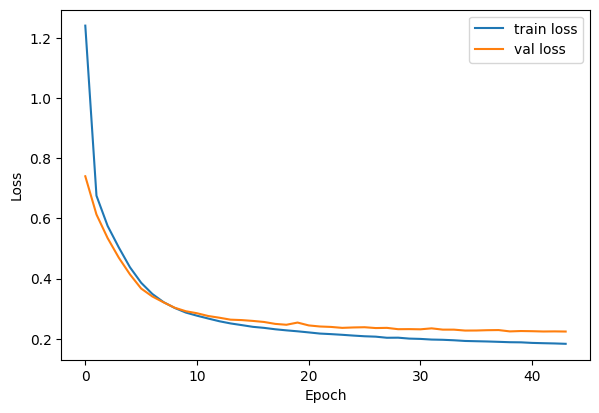

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,
    mode='min',
    restore_best_weights=True,
)
history = cnn_sparse.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, callbacks=[early_stop])

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

Epoch 1/100
391/391 [==============================] - 4s 9ms/step - loss: 1.4566 - accuracy: 0.5666 - val_loss: 0.8675 - val_accuracy: 0.7752
Epoch 2/100
391/391 [==============================] - 4s 9ms/step - loss: 0.7137 - accuracy: 0.8076 - val_loss: 0.5842 - val_accuracy: 0.8374
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5373 - accuracy: 0.8474 - val_loss: 0.4767 - val_accuracy: 0.8639
Epoch 4/100
391/391 [==============================] - 4s 9ms/step - loss: 0.4580 - accuracy: 0.8675 - val_loss: 0.4230 - val_accuracy: 0.8758
Epoch 5/100
391/391 [==============================] - 4s 9ms/step - loss: 0.4108 - accuracy: 0.8792 - val_loss: 0.3817 - val_accuracy: 0.8867
Epoch 6/100
391/391 [==============================] - 4s 9ms/step - loss: 0.3757 - accuracy: 0.8890 - val_loss: 0.3582 - val_accuracy: 0.8972
Epoch 7/100
391/391 [==============================] - 4s 9ms/step - loss: 0.3508 - accuracy: 0.8958 - val_loss: 0.3496 - val_accuracy: 0.8962

Text(0, 0.5, 'Loss')

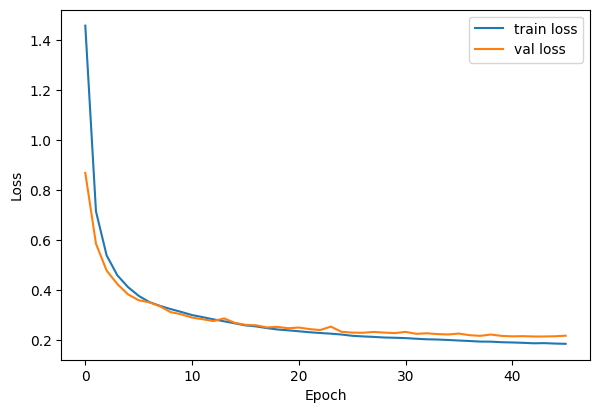

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,
    mode='min',
    restore_best_weights=True,
)
history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=128, callbacks=[early_stop])

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [13]:
y_pred_sparse = cnn_sparse.predict(x_test)
y_pred_full = cnn_full.predict(x_test)
print("accuracy (sparse cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse, axis=1))))
print("accuracy (full cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_full, axis=1))))

313/313 [==============================] - 1s 2ms/step
accuracy (sparse cnn) = 0.9359
accuracy (full cnn) = 0.9386


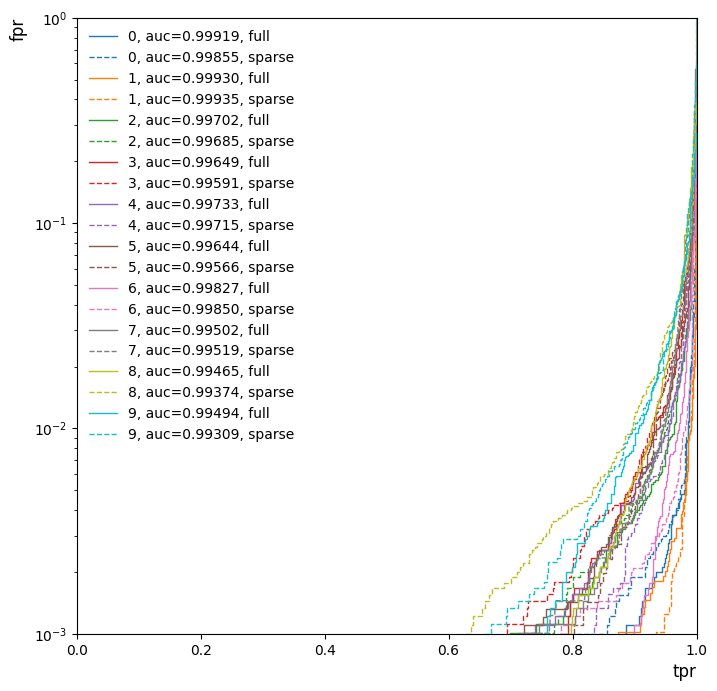

In [14]:
def plot_roc(y_test, y_pred_sparse, y_pred_full, labels):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for x, label in enumerate(labels):
        color = colors[x % len(colors)]
        fpr_full, tpr_full, _ = roc_curve(y_test[:, x], y_pred_full[:, x])
        plt.plot(tpr_full, fpr_full, label='{0}, auc={1:.5f}, full'.format(label, auc(fpr_full, tpr_full)), linestyle='-', lw=1, color=color)
        fpr_sparse, tpr_sparse, _ = roc_curve(y_test[:, x], y_pred_sparse[:, x])
        plt.plot(tpr_sparse, fpr_sparse, label='{0}, auc={1:.5f}, sparse'.format(label, auc(fpr_sparse, tpr_sparse)), linestyle='--', lw=1, color=color)
    plt.semilogy()
    plt.xlabel("tpr", size=12, loc='right')
    plt.ylabel("fpr", size=12, loc='top')
    plt.xlim(0, 1)
    plt.ylim(0.001, 1)
    plt.legend(loc='best', framealpha=0., prop={'size': 10})

plt.figure(figsize=(8, 8))
plot_roc(y_test, y_pred_sparse, y_pred_full, ['0','1','2','3','4','5','6','7','8','9'])

1/1 [==============================] - 0s 115ms/step


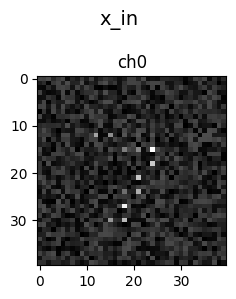

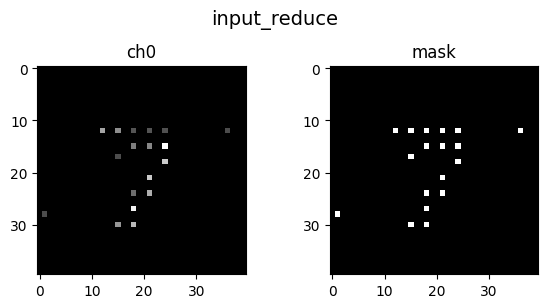

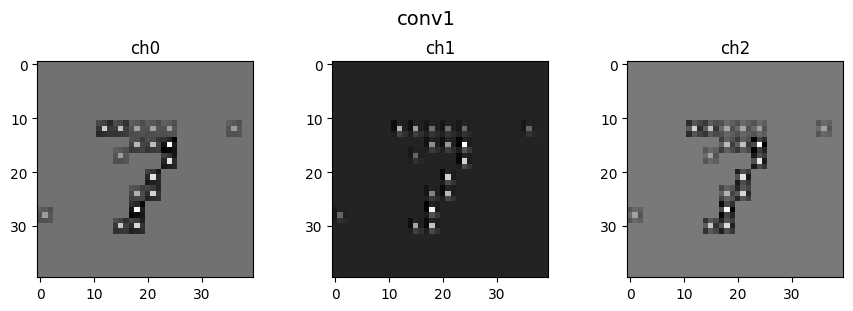

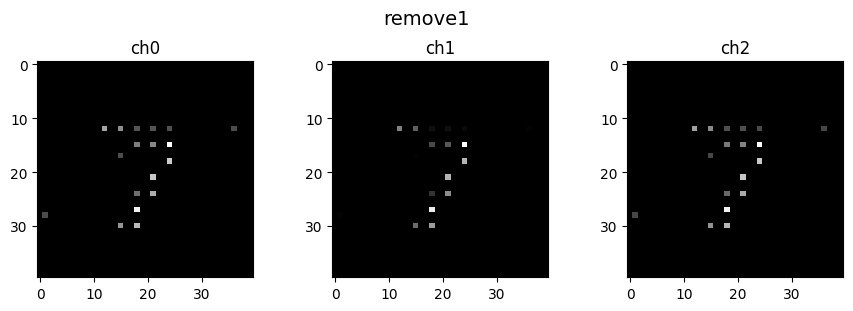

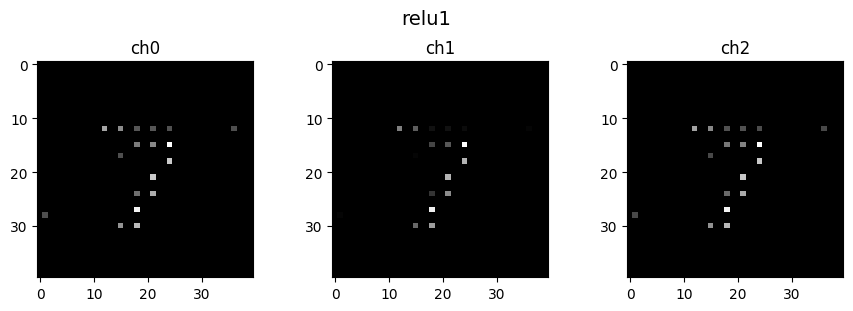

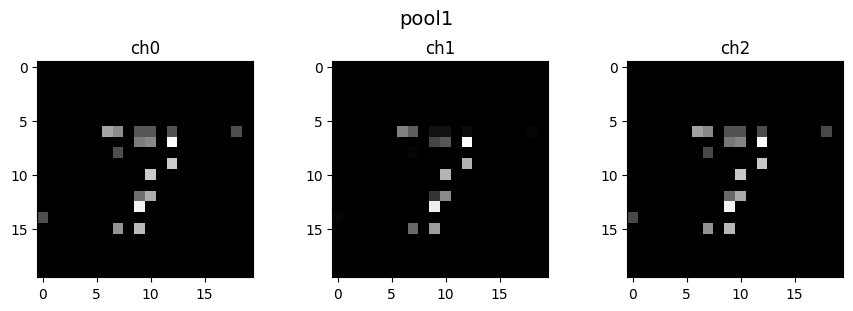

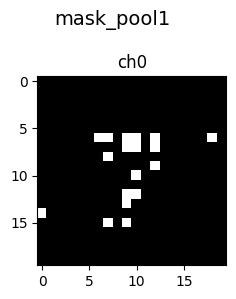

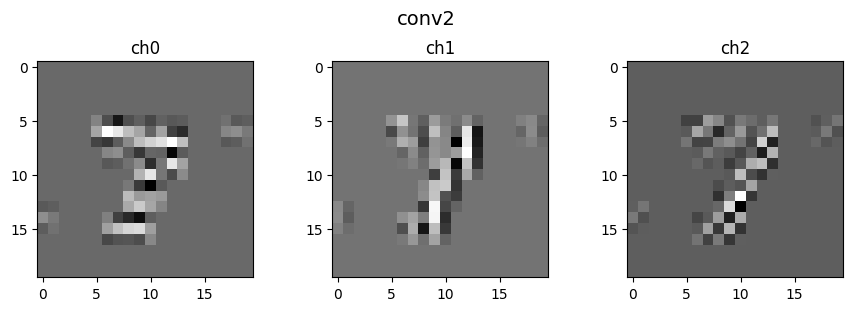

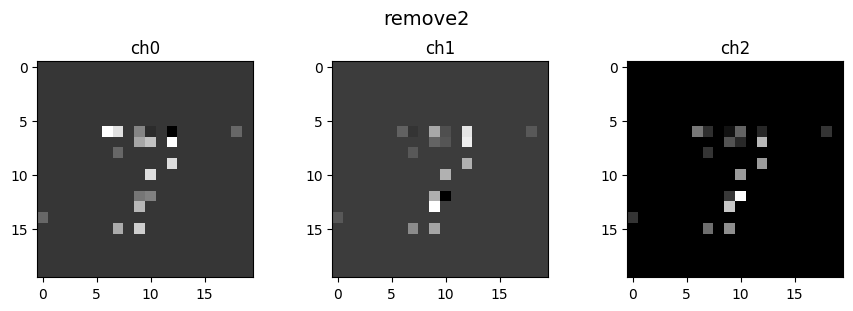

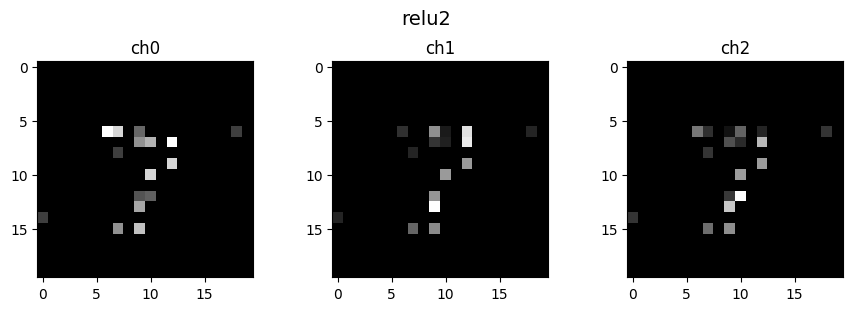

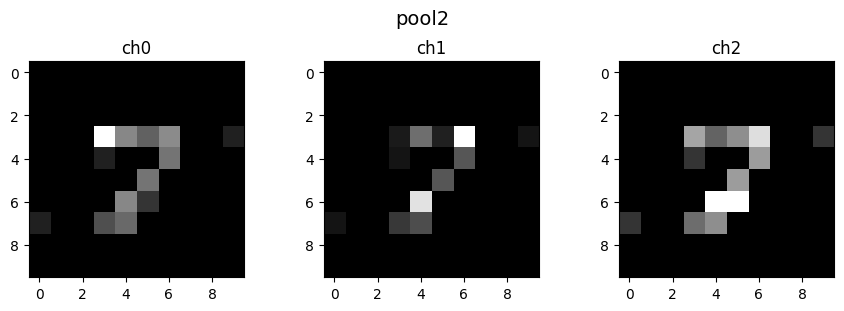

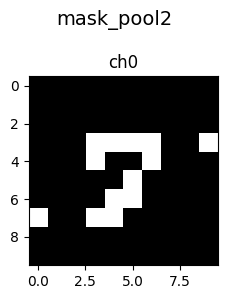

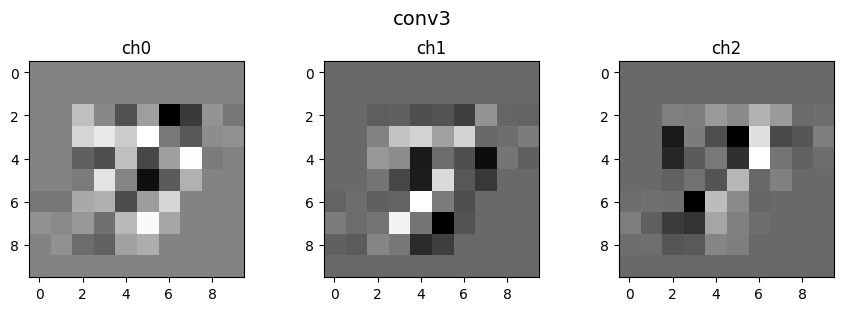

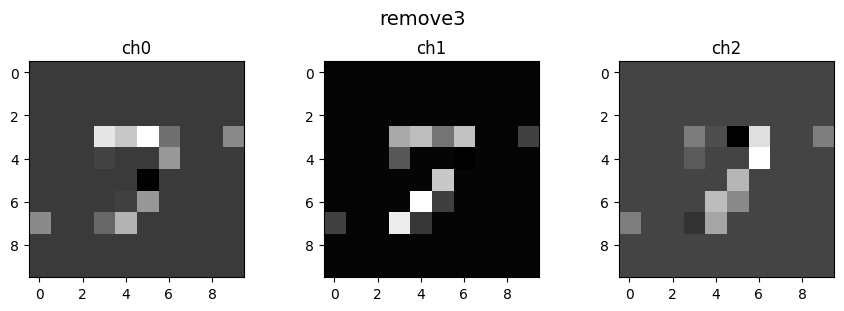

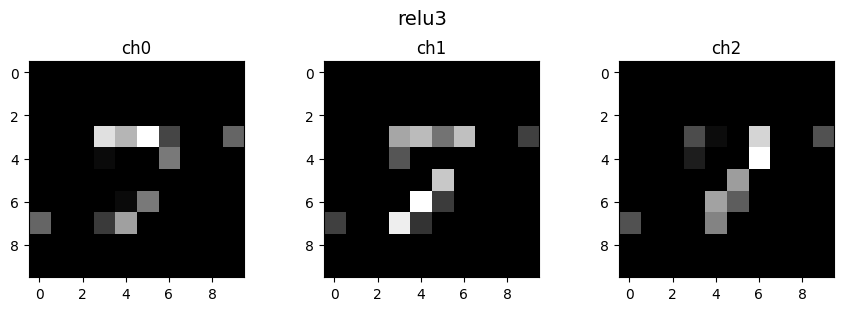

In [15]:
layer_names = [
    'x_in', 'input_reduce',
    'conv1', 'remove1', 'relu1',
    'pool1', 'mask_pool1',
    'conv2', 'remove2', 'relu2',
    'pool2', 'mask_pool2',
    'conv3', 'remove3', 'relu3',
]

plot_tensors = []
plot_names = []
for name in layer_names:
    layer = cnn_sparse.get_layer(name)
    output = layer.output
    if isinstance(output, (list, tuple)):
        plot_tensors.append(output[0])
        plot_names.append(f'{name} (x_reduced)')
        plot_tensors.append(output[1])
        plot_names.append(f'{name} (x_mask)')
    else:
        plot_tensors.append(output)
        plot_names.append(name)

model_cnnpart = models.Model(inputs=cnn_sparse.input, outputs=plot_tensors)
layers_pred = model_cnnpart.predict(x_test[0:1])

i = 0
while i < len(plot_names):
    name = plot_names[i]

    if "(x_reduced)" in name and i+1 < len(plot_names) and "(x_mask)" in plot_names[i+1]:
        out_r = layers_pred[i] # (1, h, w, c)
        out_m = layers_pred[i+1] # (1, h, w, 1)

        arr_r = out_r[0] # (h, w, c)
        arr_m = out_m[0,...,0] # (h, w)
        h, w, c = arr_r.shape

        fig, axes = plt.subplots(1, c+1, figsize=((c+1)*3, 3))
        fig.suptitle(name.replace(" (x_reduced)", ""), fontsize=14)

        for ch in range(c):
            ax = axes[ch]
            ax.imshow(arr_r[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")

        axm = axes[c]
        axm.imshow(arr_m, cmap='gray')
        axm.set_title("mask")

        plt.tight_layout()
        plt.show()

        i += 2
        continue

    out = layers_pred[i]
    arr = out[0]

    if arr.ndim == 2:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        fig.suptitle(name, fontsize=14)
        ax.imshow(arr, cmap='gray')
        ax.set_title("ch0")
        plt.tight_layout()
        plt.show()

    elif arr.ndim == 3:
        h, w, c = arr.shape
        fig, axes = plt.subplots(1, c, figsize=(c*3, 3))
        fig.suptitle(name, fontsize=14)
        for ch in range(c):
            ax = axes[ch] if c>1 else axes
            ax.imshow(arr[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")
        plt.tight_layout()
        plt.show()

    i += 1